### Remotely retrievable allometric relationships for gambel oak and new mexico locust in northern New Mexico
##### Dan J. Krofcheck, Marcy L. Litvak, Matthew D. Hurteau

Here we present the field generated relationships between height, volume, and dry biomass for two of the most pervasive post-fire shrub species in northern New Mexico.

Low cost photogrammetry projects from either manned or unmanned aircraft can leverage high image overlap to produce 3-dimensional point clouds of surface features, interpolate ground terrain, and gain some crude multi-spectral capabilities such as pseudo-NDVI with the use of makeshift filters. 
    


#### Few project bookkeeping steps for managing the analysis in Python 3
Inclusions of GDAL here is for the next steps, and the application of these equations (and the PJ work which is largely completed) with UAS imagery. The virtual_env effort up front will be worth it when we start applying these equations to clouds of points associated with classified objects like shrubs or trees. Other than that, all of the fitting is handled via pandas dataframes and the statsmodels and scipy libraries.

In [8]:
# ------- Notebook Config ------- #
%matplotlib inline
import matplotlib.pyplot as plt

# ------- Libraries ------------- #
import pandas as pd
import numpy as np
import seaborn as sns
import gdal, os, osr
from scipy import stats

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.regression.quantile_regression import QuantReg
from statsmodels.sandbox.regression.predstd import wls_prediction_std

# Working directory
dataDir = 'C:/Research/JemezAllometries/'

#### A few calc and plotting functions to help out along the way

In [93]:
def volcalc(a,b,height):
    volume = (4/3.) * (a/2) * (b/2) * height * np.pi
    return volume

def linfit(fitfunc, df):
    ols = smf.ols(fitfunc, df).fit()
    slope = (ols.params[1])
    intercept = (ols.params[0])
    return slope, intercept

def plotLinFit(slope, intercept, Xmin, Xmax, ax=None, *args, **kwargs):
    y = []
    if ax == None:
        ax = plt.gca()
    for num in np.arange(Xmin, Xmax, 0.5):
         y.append(intercept + slope*num)
    ax.plot(np.arange(Xmin, Xmax, 0.5), y,*args, **kwargs)

### Read in the combined allometric data and calculate a volume field. 
We then subset the data by species to determine the impact on fit if we are unable to ID the shrub. Only useful if the implication is that we are planning on driving these allometries remotely - something I want to stress in the paper. Otherwise, we should have just measured stem diameters like the rest of the world.

In [46]:
master = pd.read_csv('jemez_allometry_master.csv')
master['volume'] = volcalc(master['a'], master['b'], master['height'])

rone = master[master.species == 'RONE']
quga = master[master.species == 'QUGA']
quga_289 = quga[quga.site == 'jfsp_289']
quga_vcp = quga[quga.site == 'vcp']

### Show the distributions of data
Here its important to point out that the data collected at the VCP site is composed of many small individuals. It may be worth discussing a 'growth morphology' flag to separate the stick or spheroid individuals. We can easily determine which we would be using remotely using some measure of how spherical something is.

Notice the distributions of volumes here are biased left, when we combine the data from both sites this is even more true, given the greater stem density and smaller stature of the quga growing at the VCP site.

C:\Anaconda\envs\nmegrs\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Anaconda\envs\nmegrs\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Anaconda\envs\nmegrs\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Anaconda\envs\nmegrs\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


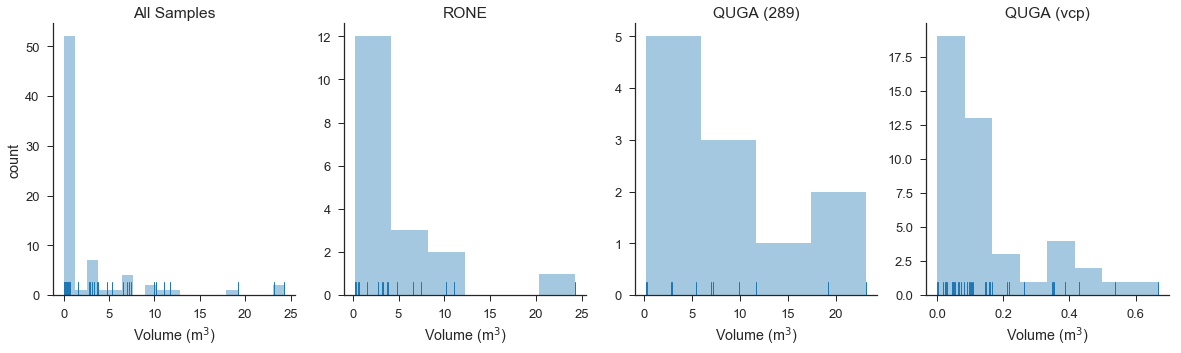

In [62]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize = (20,5))
axs = f.axes    
sns.distplot(master.volume,ax = ax1, kde=False, rug=True)
sns.distplot(rone.volume,ax = ax2, kde=False, rug=True)
sns.distplot(quga_289.volume,ax = ax3, kde=False, rug=True)
sns.distplot(quga_vcp.volume,ax = ax4, kde=False, rug=True)

ax1.set_title('All Samples')
ax2.set_title('RONE')
ax3.set_title('QUGA (289)')
ax4.set_title('QUGA (vcp)')

for ax in axs:
    ax.set_xlabel('Volume (m$^{3}$)')
ax1.set_ylabel('count')
sns.despine()

### We expect the biomass of the shrub to be proportional to its volume
This isn't ground breaking science. Lets quickly plot some simple scatters and least squares fit lines to see how things look for each of the distributions shown above.

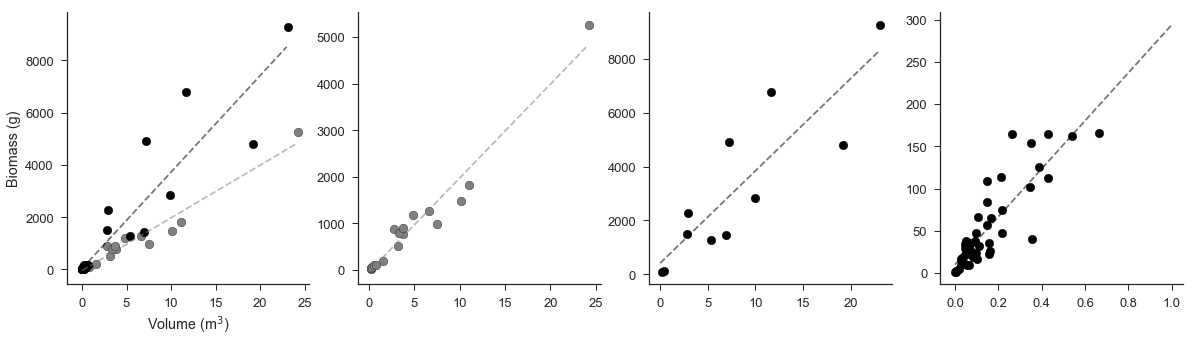

In [82]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize = (20,5))
axs = f.axes    

idx = 0
colors = ['gray','black']

for spec in ['RONE','QUGA']:
    toPlot = master[master.species == spec]
    ax1.scatter(toPlot.volume, toPlot.biomass_t, 
                color = colors[idx], marker = 'o',  
                edgecolor='k', s = 75)
    idx += 1
idx = 0   
for df in [rone, quga]:
    slope, intercept = linfit('biomass_t ~ volume', df)
    plotLinFit(slope, intercept, df.volume.max(), ax = ax1, ls = '--', color = colors[idx], alpha = 0.55)
    idx += 1


ax2.scatter(rone.volume, rone.biomass_t, 
        color = colors[0], marker = 'o',  
        edgecolor='k', s = 75)
slope, intercept = linfit('biomass_t ~ volume', rone)
plotLinFit(slope, intercept, rone.volume.max(), ax = ax2, ls = '--', color = colors[0], alpha = 0.55)

ax3.scatter(quga_289.volume, quga_289.biomass_t, 
        color = colors[1], marker = 'o',  
        edgecolor='k', s = 75)
slope, intercept = linfit('biomass_t ~ volume', quga_289)
plotLinFit(slope, intercept, quga_289.volume.max(), ax = ax3, ls = '--', color = colors[1], alpha = 0.55)

ax4.scatter(quga_vcp.volume, quga_vcp.biomass_t, 
        color = colors[1], marker = 'o',  
        edgecolor='k', s = 75)
slope, intercept = linfit('biomass_t ~ volume', quga_vcp)
plotLinFit(slope, intercept, 2, ax = ax4, ls = '--', color = colors[1], alpha = 0.55)


    
ax.legend(['rone','quga'], fontsize = 15, loc = 0)
idx = 0

ax1.set_ylabel('Biomass (g)')
ax1.set_xlabel('Volume (m$^{3}$)')

sns.despine()
sns.set_style('ticks')
sns.set_context('notebook', font_scale=1.3)

### Several prominent papers in the field of allometry
both new and old, have had recent discussions on bivariate distributions, and the wide misconceptions regarding power law applications to biomass prediction, log transformations vs weibull modeling etc. We have a clear path forward, choosing to fit separate models to young (small) and old (large) individuals, and by including species as a covariate. This way we can get along just fine taking the natural log of both biomass and volume to fit the model, then back-transforming the model with the inclusion of the correction factor and associated regression error (e.g., Baskerville 1972).

Below is the log transformed model performance for all species and sizes

In [99]:
fitData = pd.DataFrame(dict(
                            SPECIES = master['species'],
                            SITE    = master['site'],
                            VOLUME  = np.log(master['volume']),
                            BIOMASS = np.log(master['biomass_t']/1000)))

ols = smf.ols('BIOMASS ~ VOLUME', fitData).fit()
slope = (ols.params['VOLUME'])
intercept = (ols.params['Intercept'])

print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:                BIOMASS   R-squared:                       0.923
Model:                            OLS   Adj. R-squared:                  0.921
Method:                 Least Squares   F-statistic:                     845.7
Date:                Wed, 31 Oct 2018   Prob (F-statistic):           3.57e-41
Time:                        15:25:13   Log-Likelihood:                -62.010
No. Observations:                  73   AIC:                             128.0
Df Residuals:                      71   BIC:                             132.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.2838      0.075    -17.204      0.0

#### Now we can split that up into both QUGA and RONE components

In [100]:
quga = fitData[fitData.SPECIES == 'QUGA']
rone = fitData[fitData.SPECIES == 'RONE']

ols_quga = smf.ols('BIOMASS ~ VOLUME', quga).fit()
slope_quga = (ols_quga.params['VOLUME'])
intercept_quga = (ols_quga.params['Intercept'])

ols_rone = smf.ols('BIOMASS ~ VOLUME', rone).fit()
slope_rone = (ols_rone.params['VOLUME'])
intercept_rone = (ols_rone.params['Intercept'])

#### QUGA (two site model)

In [32]:
print(ols_quga.summary())

                            OLS Regression Results                            
Dep. Variable:                BIOMASS   R-squared:                       0.918
Model:                            OLS   Adj. R-squared:                  0.916
Method:                 Least Squares   F-statistic:                     592.0
Date:                Wed, 31 Oct 2018   Prob (F-statistic):           1.97e-30
Time:                        13:53:34   Log-Likelihood:                -47.649
No. Observations:                  55   AIC:                             99.30
Df Residuals:                      53   BIC:                             103.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.1246      0.101    -11.145      0.0

#### RONE

In [33]:
print(ols_rone.summary())

                            OLS Regression Results                            
Dep. Variable:                BIOMASS   R-squared:                       0.974
Model:                            OLS   Adj. R-squared:                  0.972
Method:                 Least Squares   F-statistic:                     594.1
Date:                Wed, 31 Oct 2018   Prob (F-statistic):           4.45e-14
Time:                        13:53:37   Log-Likelihood:              -0.098542
No. Observations:                  18   AIC:                             4.197
Df Residuals:                      16   BIC:                             5.978
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.7581      0.069    -25.344      0.0

C:\Anaconda\envs\nmegrs\lib\site-packages\scipy\stats\stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  "anyway, n=%i" % int(n))


### Moving toward a more robust prediction
We should do some model fitting work, namely some cross validation. LOOCV is the best approach to use here given the small sample size and lack of computation complexity. Let's run it on our model and see how it performs. I expect given the strong bivariate distribution of our data, LOOCV will prove to be fairly robust. A k-folds approach would actually poke more holes in the effort here, but thats beside the point given that we will probably report the total and 'small' allometries as separate entities in an effort to be as robust as possible.

In [117]:
import sklearn.linear_model as skl_lm
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

lm = skl_lm.LinearRegression()

allShrubs = lm.fit(fitData.BIOMASS.values.reshape(-1,1), fitData.VOLUME)

loo = LeaveOneOut()
X = fitData.BIOMASS.values.reshape(-1,1)
y = fitData.VOLUME.values.reshape(-1,1)
splitnums = loo.get_n_splits(X)


crossvalidation = KFold(n_splits=splitnums, random_state=None, shuffle=False)

scores = cross_val_score(allShrubs, X, y, scoring="neg_mean_squared_error", cv=crossvalidation,
    n_jobs=1)

print("Folds: " + str(len(scores)) + ", MSE: " + str(np.mean(np.abs(scores))) + ", STD: " + str(np.std(scores)))

Folds: 73, MSE: 0.42904332024106273, STD: 0.9664833515810669


### If we look at the resulting transformed data
The accuracy of the resulting linear model is obvious. We need to think about taking the MSE from the LOOCV and adding it into the model uncertainty term, but the current framework should make that fairly straight forward if we decide to do it. We can produce these curves for either all shrubs, or the separated species.

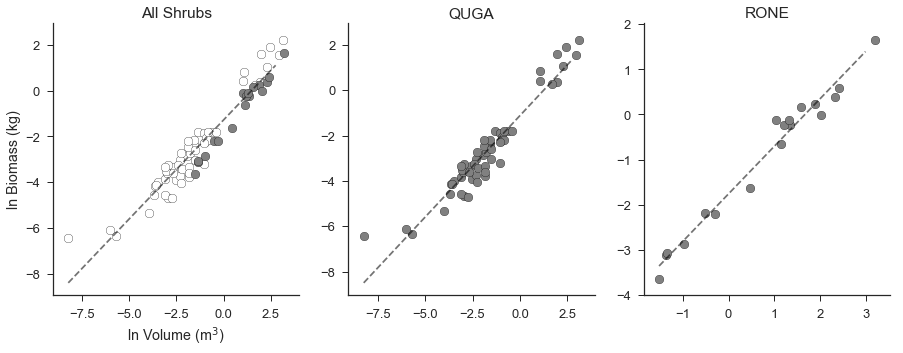

In [142]:
f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (15,5))

slope, intercept = linfit('BIOMASS ~ VOLUME', fitData)
plotLinFit(slope, intercept, fitData.VOLUME.min(), fitData.VOLUME.max(), 
           ax = ax1,ls = '--', color = 'k', alpha = 0.55)

slope, intercept = linfit('BIOMASS ~ VOLUME', quga)
plotLinFit(slope, intercept, quga.VOLUME.min(), quga.VOLUME.max(), 
           ax = ax2,ls = '--', color = 'k', alpha = 0.55)

slope, intercept = linfit('BIOMASS ~ VOLUME', rone)
plotLinFit(slope, intercept, rone.VOLUME.min(), rone.VOLUME.max(), 
           ax = ax3,ls = '--', color = 'k', alpha = 0.55)


ax1.scatter(quga.VOLUME, quga.BIOMASS, 
        color = 'white', marker = 'o',  
        edgecolor='k', s = 75)

ax1.scatter(rone.VOLUME, rone.BIOMASS, 
        color = 'gray', marker = 'o',  
        edgecolor='k', s = 75)

ax2.scatter(quga.VOLUME, quga.BIOMASS, 
        color = 'gray', marker = 'o',  
        edgecolor='k', s = 75)

ax3.scatter(rone.VOLUME, rone.BIOMASS, 
        color = 'gray', marker = 'o',  
        edgecolor='k', s = 75)




ax1.set_ylabel('ln Biomass (kg)')
ax1.set_xlabel('ln Volume (m$^{3}$)')

ax1.set_title('All Shrubs')
ax2.set_title('QUGA')
ax3.set_title('RONE')

sns.despine()
sns.set_style('ticks')

### What proportion of these shrubs are foliar vs wood?

### What are the size to foliage relationships we can expect given the total biomass relationships?

### TO DO:
I think we should bootstrap the regressions using the standard error or variance of as many sources of uncertainty as we can manage, including measurement uncertainty from tapes and balances. We can use a simple MC approach to building the model, the net effect is just an increase in the uncertainty of the regressions. We can afford that given the high R2, but when we translate the uncertainty in terms of biomass the numbers are still tiny, but relatively large in some cases.

We also need to address the consequences of how uncertainty is bracketed for large or small shrubs, and by species. I am thinking about a section in the pub in the results or discussion related to the contextualization of the allometry for remote retrieval from high resolution remote sensing (satellite or UAS). In that effort I want to calculate the ellopsoid cross sectional area and run the same models soley with 2D inputs.